In [60]:
import torch
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt

In [65]:
muscle_parameters = {
    "lmin": 0.24,
    "lmax": 1.53,
    "fvman": 1.38,
    "fpmax": 1.76,
    "fmin": 0.1,
    "lce_max": 1.0,
    "peak_force": 34,
    "eps": 10e-6,
    "dt":0.002,
    "num_envs": 1,
    "num_joints": 12,
    "device": "cpu",
    "angles": torch.Tensor([[-1.0472, 1.0472], [-1.0472, 1.0472], [-1.0472, 1.0472], [-1.0472, 1.0472], [-1.5708, 3.4907], [-1.5708, 3.4907], [-0.5236, 4.5379], [-0.5236, 4.5379], [-2.7227, -0.8378], [-2.7227, -0.8378], [-2.7227, -0.8378], [-2.7227, -0.8378]])
}

In [62]:
from __future__ import annotations
import torch

from scipy.optimize import bisect

class MuscleActuator:
    def __init__(self, muscle_params, *args, **kwargs):
        
        self.muscle_params = muscle_params

        for key, value in self.muscle_params.items():
            setattr(self, key, value)

        for key, value in kwargs:
            setattr(self, key, value)

        self.phi_min = self.angles[:, 0]
        
        self.phi_max = self.angles[:, 1]

        self.activation_tensor = torch.zeros(
            (self.num_envs, self.num_joints * 2),
            dtype=torch.float32,
            device=self.device,
            requires_grad=False,
        )

        self.lce_tensor = torch.zeros(
            (self.num_envs, self.num_joints * 2),
            dtype=torch.float32,
            device=self.device,
            requires_grad=False,
        )
        self.lce_dot_tensor = torch.zeros(
            (self.num_envs, self.num_joints * 2),
            dtype=torch.float32,
            device=self.device,
            requires_grad=False,
        )
        self.force_tensor = torch.zeros(
            (self.num_envs, self.num_joints * 2),
            dtype=torch.float32,
            device=self.device,
            requires_grad=False,
        )
       
        self.moment, self.lce_ref = self._compute_parametrization()

    def _FL(self, lce: torch.Tensor) -> torch.Tensor:
        """
        Force length
        """
        length = lce
        b1 = self._bump(length, self.lmin, 1, self.lmax)
        b2 = self._bump(length, self.lmin, 0.5 * (self.lmin + 0.95), 0.95)
        bump_res = b1 + 0.15 * b2
        return bump_res
    
    def _calc_l_min(self, Fmin, tol=10e-7):
        def f(l_ce):
            return self._FL(torch.tensor([l_ce], device=self.device)) - Fmin
        
        mid = 1.0
        return bisect(lambda x: f(x), self.lmin + 10e-9, mid - 10e-9, xtol=tol)

    def _bump(self, length: torch.Tensor, A: float, mid: float, B: float) -> torch.Tensor:
        """
        skewed bump function: quadratic spline
        Input:
            :length: tensor of muscle lengths [Nenv, Nactuator]
            :A: scalar
            :mid: scalar
            :B: scalar

        Returns:
            :torch.Tensor: contains FV result [Nenv, Nactuator]
        """

        left = 0.5 * (A + mid)
        right = 0.5 * (mid + B)
        # Order of assignment needs to be inverse to the if-else-clause case
        bump_result = torch.ones(
            (self.num_envs, self.num_joints * 2),
            dtype=torch.float32,
            device=self.device,
            requires_grad=False,
        )

        x = (B - length) / (B - right)
        bump_result = 0.5 * x**2

        x = (length - mid) / (right - mid)
        bump_result = torch.where(length < right, 1 - 0.5 * x**2, bump_result)

        x = (mid - length) / (mid - left)
        bump_result = torch.where(length < mid, 1 - 0.5 * x**2, bump_result)

        x = (length - A) / (left - A)
        bump_result = torch.where((length < left) & (length > A), 0.5 * x**2, bump_result)

        bump_result = torch.where(
            torch.logical_or((length <= A), (length >= B)),
            torch.tensor([0], dtype=torch.float32, device=self.device),
            bump_result,
        )
        return bump_result
    
    def compute_virtual_lengths(self, actuator_pos: torch.Tensor) -> None:
        """
        Compute muscle fiber lengths l_ce depending on joint angle
        Attention: The mapping of actuator_trnid to qvel is only 1:1 because we have only
        slide or hinge joints and no free joint!!! Otherwise you have to build this mapping
        by looking at every single joint type.

        self.lce_x_tensor contains copy of given actions (they represent the actuator position)
        """
        # Repeat position tensor twice, because both muscles are computed from the same actuator position
        # the operation is NOT applied in-place to the original tensor, only the result is repeated.
        self.lce_tensor = torch.add(torch.mul(actuator_pos.repeat(1, 2), self.moment), self.lce_ref)
        
        #TODO remove later
        return self.lce_tensor
    
    def _compute_parametrization(self):
        """
        Find parameters for muscle length computation.
        This should really only be done once...

        We compute them as one long vector now.
        """

        self.lce_min = self._calc_l_min(self.fmin)

        moment = torch.zeros((self.num_envs, self.num_joints * 2))
        moment[:, : int(moment.shape[1] // 2)] = (self.lce_max - self.lce_min) / (self.phi_max - self.phi_min)
        moment[:, int(moment.shape[1] // 2) :] = (self.lce_max - self.lce_min) / (self.phi_min - self.phi_max)
        lce_ref = torch.zeros((self.num_envs, self.num_joints * 2))
        lce_ref[:, : int(lce_ref.shape[1] // 2)] = self.lce_min - moment[:, : int(moment.shape[1] // 2)] * self.phi_min
        lce_ref[:, int(lce_ref.shape[1] // 2) :] = self.lce_min - moment[:, int(moment.shape[1] // 2) :] * self.phi_max
        return moment, lce_ref
    
    def get_vel(self, moment, actuator_vel: torch.Tensor) -> torch.Tensor:
        """
        For muscle 1, the joint angle increases if it pulls. This means
        that the joint and the muscle velocity have opposite signs. But this is already
        included in the value of the moment arm. So we don't need if/else branches here.
        Attention: The mapping of actuator_trnid to qvel is only 1:1 because we have only
        slide or hinge joints and no free joint!!! Otherwise you have to build this mapping
        by looking at every single joint type.
        """
        return torch.mul(actuator_vel.repeat(1, 2), moment)

    def activ_dyn(self, actions: torch.Tensor) -> None:
        """
        Activity and controls have to be written inside userdata. Assume
        two virtual muscles per real mujoco actuator and let's roll.
        """
        sim_timestep = 0.005
        self.activation_tensor = 100 * (actions - self.activation_tensor) * sim_timestep + self.activation_tensor
        self.activation_tensor = torch.clip(self.activation_tensor, 0, 1)
        # self.activation_tensor = torch.mul(torch.mul(torch.sub(actions,self.activation_tensor), 100), torch.add(self.activation_tensor, sim_timestep))

    def compute_moment(self, actuator_vel):
        """
        Joint moments are computed from muscle contractions and then returned
        """

        self.lce_dot_tensor = self.get_vel(self.moment, actuator_vel)
        lce_dot = self.lce_dot_tensor
        lce_tensor = self.lce_tensor

        FL = self._FL(lce_tensor)
        FV = 1.0 #self.FV(lce_dot)
        FP = 0.0 #self.FP(lce_tensor)

        #self.force_tensor = torch.add(torch.mul(torch.mul(FL, FV), self.activation_tensor), FP)
        F = self.peak_force * (FL * FV * self.activation_tensor  + FP)
        torque = F * self.moment

        return torch.sum(
            torch.reshape(torque, (self.nenvironments, 2, self.nactioncount // 2)),
            axis=-2,
        )
    
    def FV(self, lce_dot: torch.Tensor) -> torch.Tensor:
        """
        Force velocity
        Input:
            :lce_dot: tensor of muscle velocities [Nenv, Nactuator]
        """
        c = self.fvmax - 1
        velocity = lce_dot

        eff_vel = torch.div(velocity, self.vmax)

        c_result = torch.zeros_like(
            eff_vel,
            dtype=torch.float32,
            device=self.device,
            requires_grad=False,
        )

        c_result = torch.where(
            (eff_vel > c),
            torch.tensor([self.fvmax], dtype=torch.float32, device=self.device),
            c_result,
        )

        x = torch.sub(
            self.fvmax,
            torch.div(torch.mul(torch.sub(c, eff_vel), torch.sub(c, eff_vel)), c),
        )
        c_result = torch.where(eff_vel <= c, x, c_result)

        x = torch.mul(torch.add(eff_vel, 1), torch.add(eff_vel, 1))
        c_result = torch.where(eff_vel <= 0, x, c_result)

        c_result = torch.where(
            (eff_vel < -1),
            torch.tensor([0], dtype=torch.float32, device=self.device),
            c_result,
        )

        return c_result

    def FP(self, lce: torch.Tensor) -> torch.Tensor:
        """
        Force passive
        Inputs:
            :lce: muscle lengths [Nenv, Nactuator]
        return :fp_result: passive_force [Nenv, Nactuator]
        """
        b = 0.5 * (self.lmax + 1)

        # Order of assignment needs to be inverse to the if-else-clause case
        ## method to prevent
        cond_2_tmp = torch.div(torch.sub(lce, 1), (b - 1))
        cond_2 = torch.mul(
            torch.mul(torch.mul(cond_2_tmp, cond_2_tmp), cond_2_tmp),
            (0.25 * self.fpmax),
        )

        cond_3_tmp = torch.div(torch.sub(lce, b), (b - 1))
        cond_3 = torch.mul(torch.add(torch.mul(cond_3_tmp, 3), 1), (0.25 * self.fpmax))
        ##### copy based on condition the correct output into new tensor
        c_result = torch.zeros_like(lce, dtype=torch.float32, device=self.device, requires_grad=False)
        c_result = torch.where(lce <= b, cond_2, c_result)
        c_result = torch.where(
            lce <= 1,
            torch.tensor([0], dtype=torch.float32, device=self.device),
            c_result,
        )
        c_result = torch.where(lce > b, cond_3, c_result)

        return c_result

    def compute_torques(self, actuator_pos, actuator_vel, actions: torch.Tensor):
        """
        actuator_pos: Current position of actuator
        """
        with torch.torch.no_grad():
            actions = torch.clip(actions, 0, 1)

            # activity funciton for muscle activation
            self.activ_dyn(actions)

            # update virtual lengths
            self.compute_virtual_lengths(actuator_pos)

            # compute moments
            moment = self.compute_moment(actions, actuator_vel)

            return moment

In [72]:
muscle_parameters['fmin'] = 0.1
ma = MuscleActuator(muscle_parameters)

joint_names = ['FL_hip_joint', 'FR_hip_joint', 'RL_hip_joint', 'RR_hip_joint', 'FL_thigh_joint', 'FR_thigh_joint', 'RL_thigh_joint', 'RR_thigh_joint', 'FL_calf_joint', 'FR_calf_joint', 'RL_calf_joint', 'RR_calf_joint']

joint_positions = torch.stack([
    torch.linspace(start, end, 1000) for start, end in muscle_parameters["angles"]
])

muscle_lengths = torch.stack([
    ma.compute_virtual_lengths(tensor) for tensor in joint_positions.T
]).squeeze(1)

muscle_forces = ma._FL(muscle_lengths).T

In [70]:
ma._FL(muscle_lengths).shape

torch.Size([1000, 24])

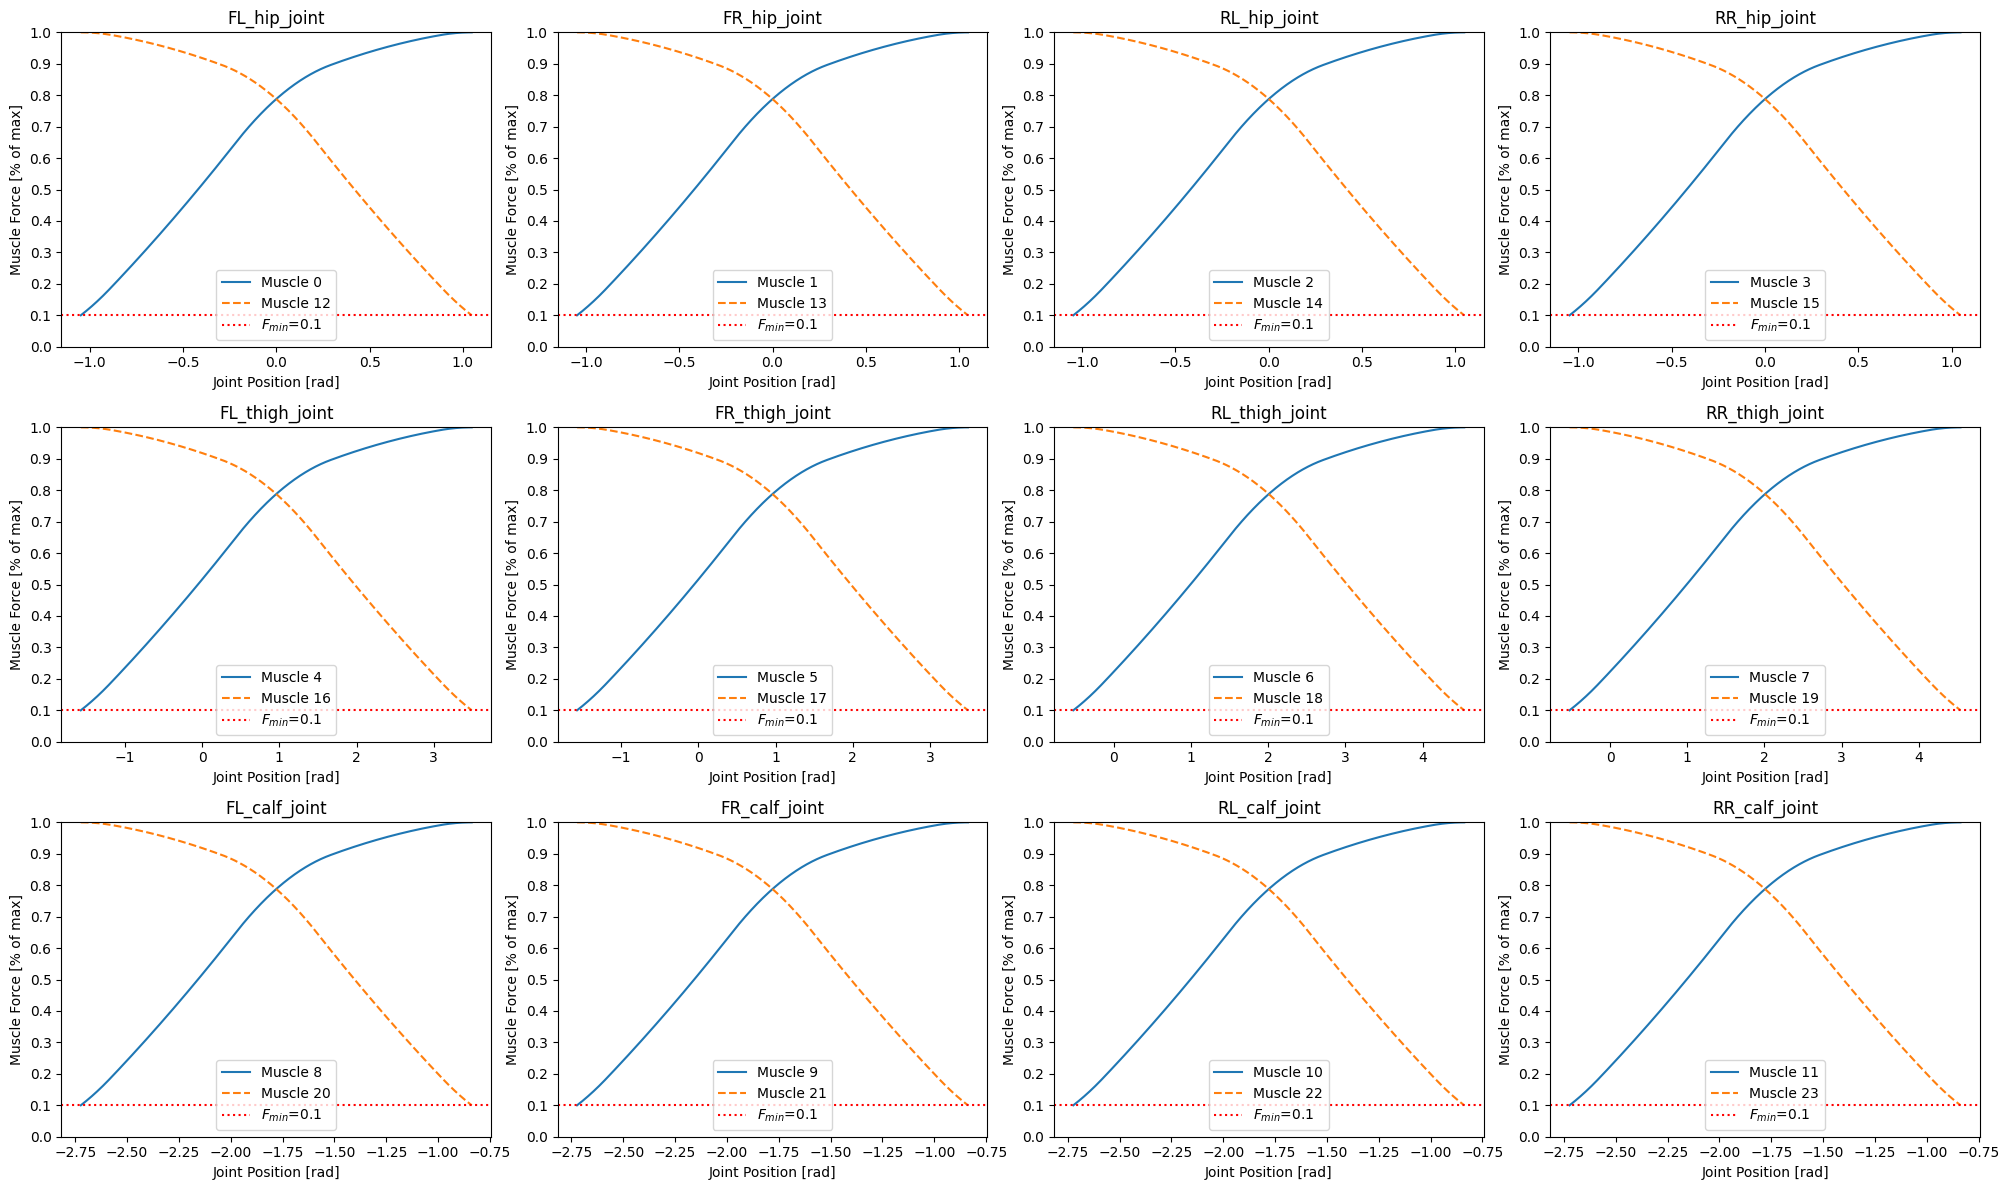

In [73]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 12))
axes = axes.flatten()

for i, ax in enumerate(axes):
    # Muscle indices for the current joint
    muscle_index_1 = i         # First muscle index
    muscle_index_2 = i + 12    # Second muscle index

    # Extract data for the current joint
    x1 = joint_positions[i]  # Muscle position for the first muscle
    y1 = muscle_forces[muscle_index_1]  # Muscle force for the first muscle

    x2 = joint_positions[i]  # Muscle position for the second muscle
    y2 = muscle_forces[muscle_index_2]  # Muscle force for the second muscle

    # Plot the two muscles in the same subplot
    ax.plot(x1, y1, label=f'Muscle {muscle_index_1}')
    ax.plot(x2, y2, label=f'Muscle {muscle_index_2}', linestyle='--')
    
    ax.axhline(y=muscle_parameters["fmin"], color='red', linestyle=':', label=f'$F_{{min}}$={muscle_parameters["fmin"]}')

    # Set the title, labels, and legend
    ax.set_title(joint_names[i])
    ax.set_xlabel('Joint Position [rad]')
    ax.set_ylabel('Muscle Force [% of max]')
    ax.legend()
    
    ax.set_ylim(0.0, 1.0)
    ax.set_yticks([round(tick, 1) for tick in np.arange(0.0, 1.1, 0.1)])


# Adjust layout to prevent overlap
plt.tight_layout()